In [1]:
import numpy as np
import QCL_simulation_18bits as cl_18q
from pickle_depository.adam import adam_log,Nadam_log
import random
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import os,sys
file_path_now = os.getcwd()
print(file_path_now)

/home/zhide_lu/Projects/Quantum_continual_leanring/Exp_quantum_continual_learning/Additional_results/Simultaneous_learning_three_tasks


In [3]:
cml = cl_18q.cml(save_paht=file_path_now)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


use random params!!!


In [4]:
def multi_learning(
        cml,
        iter_idx=0,
        max_iter=200,
        ask_stop=False,
        test=True,
        batch_size=25,
        test_num=100,
        tasks=['FashionMNIST_09','medical','spt'],
        theta2data=[2,2,2],
        lr=0.05,
        adam=True,
    ):
        tasks = tasks if isinstance(tasks, list) else [tasks]
        theta2data = theta2data if isinstance(theta2data,
                                              list) else [theta2data]
        test_num = cml.x_train[tasks[0]].shape[0] if test_num is None else test_num
        if adam:
            cml.adam_log1 = adam_log( file_path_now+"/adam/adam_log_" + 'multiple_learning' +
                                    "_params_num=%s" % (batch_size) + "_readq%s" %
                                    (cml.measure_qnum) +
                                    f'block_num={cml.block_num}' + ".pkl",
                                    lr=lr,
                                    )
        else:
            cml.adam_log1 = Nadam_log(file_path_now+"/adam/Nadam_log_"+ 'multiple_learning' +
                                    "_params_num=%s" % (batch_size) + "_readq%s" %
                                    (cml.measure_qnum) +
                                    f'block_num={cml.block_num}' + ".pkl",
                                    lr=lr,
                                    )
        random.seed(1)
        losses={}
        accs={}
        for t in tasks:
            losses[t] = []
            accs[t] = []
        while iter_idx <= max_iter:
            cml.save_params('muti_leatning', batch_size, cml.measure_qnum)
            for t in range(len(tasks)):
                amp = True if tasks[t].startswith('spt') else False
                random_perm=True if tasks[t]=='medical'  else False
                
                cml.train_idx = random.sample(
                    range(0, len(cml.x_train[tasks[t]])), batch_size)
                
                loss, accuracy_rate = cml.loss_and_accuracy(
                    cml.params,
                    theta2data[t],
                    amp=amp,
                    random_perm=random_perm,
                    task=tasks[t],
                    )


            if test:
                for t in range(len(tasks)):
                    amp = True if tasks[t].startswith('spt') else False
                    random_perm=True if tasks[t]=='medical'  else False
                    loss, accuracy_rate = cml.loss_and_accuracy(
                        cml.params,
                        theta2data[t],
                        amp=amp,
                        random_perm=random_perm,
                        test=True,
                        task=tasks[t],
                        )
                    losses[tasks[t]].append(loss)
                    accs[tasks[t]].append(accuracy_rate)
                    print(f"{'iter_idx:':<9}{iter_idx:<5} {'task:':<5}{tasks[t]:<16} {'loss:':<5}{loss:.4f} {'accuracy:':<9}{accuracy_rate:.2%}")
            gs=0
            for t in range(len(tasks)):
                amp = True if tasks[t].startswith('spt') else False
                random_perm=True if tasks[t]=='medical'  else False
                gs += cml.gradient(
                                params=cml.params,
                                task=tasks[t],
                                theta2data=theta2data[-1],
                                amp=amp,
                                random_perm=random_perm,
                                noise_level=0.0,)
            gs = gs/len(tasks)
            if adam:
                delta_theta = cml.adam_log1.log(gs, "", iter_idx)
            else:
                delta_theta = cml.adam_log1.log(gs, "", iter_idx+1)
            
            iter_idx += 1
            cml.update_params(delta_theta)
            if ask_stop:
                stop = input("stop?[y/n]")
                if stop == "y":
                    break
            with open(file_path_now+'/results/losses_and_accuracy_multiple_learning.pkl', 'wb') as f:
                pickle.dump({'losses':losses, 'accs':accs}, f)
        return  losses, accs

In [ ]:
tasks=['FashionMNIST_09','medical','spt']
batch_size = 25
lr = 0.05
max_epoch = 67
test_num = 100
adam = True #use Nadam
losses,accs=multi_learning(cml=cml,max_iter=max_epoch,batch_size=batch_size,lr=lr,tasks=tasks,test_num=test_num,adam=adam)

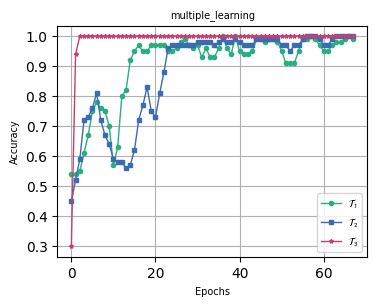

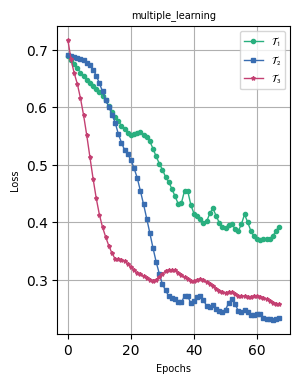

In [5]:
PAPERFIGURE = np.array([180, 247]) / 25.4  # nature
fontsize = 7
cs=['#29af7f','#396db1','#c44072']
marks = ['o','s','*']
tasks = ['FashionMNIST_09','medical','spt']

with open(file_path_now+'/results/losses_and_accuracy_multiple_learning.pkl', 'rb') as f:
        data=pickle.load( f)
losses = data['losses']
accs = data['accs']
steps = np.arange(len(accs[tasks[0]]))
#plot accuracy rate 
plt.figure(figsize=(4,3))
for task in tasks:
    plt.plot(steps,np.array(accs[task])[steps], label=fr'$\mathcal{{T}}_\mathcal{{{tasks.index(task)+1}}}$',linewidth = 1,markersize=3, c=cs[tasks.index(task)],marker=marks[tasks.index(task)])
plt.xlabel('Epochs',fontsize=fontsize)
plt.ylabel('Accuracy',fontsize=fontsize)
plt.title('multiple_learning',fontsize=7)
plt.legend(fontsize=fontsize)
plt.grid()
plt.show()
#plot loss
plt.figure(figsize=(3, 4))
for task in tasks:
    plt.plot(steps,np.array(losses[task])[steps], label=fr'$\mathcal{{T}}_\mathcal{{{tasks.index(task)+1}}}$',linewidth = 1,markersize=3, c=cs[tasks.index(task)],marker=marks[tasks.index(task)])
plt.xlabel('Epochs',fontsize=fontsize)
plt.ylabel('Loss',fontsize=fontsize)
plt.title('multiple_learning',fontsize=7)
plt.legend(fontsize = fontsize)
plt.grid()

In [6]:
dl={}
dl
for tasks in ['FashionMNIST_09', 'medical', 'spt']:
    dl[tasks]={}
    dl[tasks]['x_train'] = cml.x_train[tasks]
    dl[tasks]['y_train'] = cml.y_train[tasks]
    dl[tasks]['x_test'] = cml.x_test[tasks]
    dl[tasks]['y_test'] = cml.y_test[tasks]
with open('Data.pkl', 'wb') as f:
    pickle.dump(dl,f)